In [44]:
import torch
import torch.nn as nn

# 恒等写像
def identity(x):
    return x # pytorchのテンソルをそのまま処理可能


# 入力層
class Input(nn.Module):
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        super(Input, self).__init__()
        # 一様分布に従う乱数
        torch.manual_seed(seed)
        self.Win = nn.Parameter(torch.empty((N_u, N_x)).uniform_(-input_scale, input_scale))
        self.Win.requires_grad = False  # 勾配更新を不要にする

    def get_weight_matrix(self):
        # 入力行列Winを返す
        return self.Win

In [58]:
import torch
import torch.nn as nn
import numpy as np

class Reservoir(nn.Module):
    def __init__(self, N_x, density, rho, activation_func,  seed):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数 (torch.nn.functional)
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        super(Reservoir, self).__init__()
        self.seed = seed
        self.N_x = N_x
        self.W = self.make_connection_pytorch(N_x, density, rho, seed)
        self.W = nn.Parameter(self.W)  # Wをnn.Parameterとしてラップ
        self.x = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.W.requires_grad = False  # リザバーの重みは訓練しない

    @staticmethod
    def make_connection_pytorch(N_x, density, rho, seed):
        torch.manual_seed(seed)

        # ランダムな接続行列の生成
        connection = torch.bernoulli(torch.full((N_x, N_x), density))
        rec_scale = 1.0
        W = connection * (torch.rand((N_x, N_x)) * 2 * rec_scale - rec_scale)

        # Wが空でないことを確認
        if W.numel() == 0:
            raise ValueError("Weight matrix W is empty. Please check the matrix generation process.")

        # スペクトル半径を計算
        eigenvalues = torch.linalg.eigvals(W)
        if eigenvalues.numel() == 0:
            raise ValueError("Eigenvalues are empty. Check the matrix W.")

        sp_radius = torch.max(torch.abs(eigenvalues.real))

        # スペクトル半径をrhoにスケーリング
        W *= rho / sp_radius

        return W

    def get_weight_matrix_W(self):
        # 重み行列Wを返す
        return self.W




In [46]:
class Output(nn.Module):
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        super(Output, self).__init__()
        # 正規分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wout = nn.Parameter(torch.randn( N_x, N_y, dtype=torch.float32))
        self.Wout.requires_grad = True


    def get_weight_matrix_wout(self):
        # 出力行列Woutを返す
        return self.Wout


    def setweight(self, Wout_opt):
        '''
        学習済みの出力結合重み行列を設定
        param Wout_opt: 新しい重み行列 (torch.Tensor)
        '''
        if not isinstance(Wout_opt, torch.Tensor):
            raise ValueError("Wout_opt must be a torch.Tensor.")
        self.Wout = Wout_opt


In [47]:
import torch

class Feedback:
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wfb = (torch.rand(N_x, N_y, dtype=torch.float32) * 2 * fb_scale - fb_scale)

    def __call__(self, y):
        '''
        param y: N_y次元のベクトル (torch.Tensor)
        return: N_x次元のベクトル (torch.Tensor)
        '''
        return torch.matmul(self.Wfb, y)


In [61]:

class ESN(nn.Module):
    def __init__(self, N_u, N_y, N_x, density=0.15, input_scale=1.0, rho=0.95, activation_func=torch.tanh, fb_scale=None, fb_seed=0, noise_level=None, leaking_rate=0.8, output_func=None, classification=False, average_window=None, seed = 40):
        super(ESN, self).__init__()

        # モジュールの初期化
        self.Input = Input(N_u, N_x, input_scale)  # 入力層
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, seed) # リザバー層
        self.x_res = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.Output = Output(N_x, N_y) # リードアウトを取得


        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.activation_func = activation_func
        self.output_func = output_func if output_func is not None else lambda x: x
        self.classification = classification
        self.alpha = leaking_rate
        self.Input.requires_grad = False
        self.Reservoir.requires_grad = False

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新にノイズを加えるか
        if noise_level is None:
            self.noise = None
        else:
            self.noise = torch.rand(N_x, 1) * noise_level * 2 - noise_level  # -noise_level to +noise_level

        # 分類問題の場合の設定
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = torch.zeros((average_window, self.N_x))

        # リザバー状態の初期化
        self.reset_reservoir_state()

    def forward(self, u):
        '''
        param u: N_u次元のベクトル (torch.Tensor)
        return: N_y次元のベクトル (torch.Tensor)

        '''

        # 入力層の行列Winを取得
        Win = self.Input.get_weight_matrix()

        # 順伝播：入力uとWinを掛け算して、リザバー状態を更新
        x_in = torch.matmul(u, Win)

        # リザバーの行列Wを取得
        W = self.Reservoir.get_weight_matrix_W()


        # 順伝播：
        x_res =  (1.0 - self.alpha) * self.x_res + self.alpha * self.activation_func(torch.matmul(W, self.x_res) + x_in)

        # リードアウトの行列Woutを取得
        Wout = self.Output.get_weight_matrix_wout()
        #print("Wout requires_grad:", Wout.requires_grad)

        #print(Wout)
        # 順伝播：
        y = torch.matmul(x_res, Wout)



        # フィードバックがある場合の処理
        if self.Feedback is not None:
            self.x += self.Feedback(self.x)

        # ノイズの追加
        if self.noise is not None:
            self.x += self.noise

        # 学習前のモデル出力

        return y

    def reset_reservoir_state(self):
        '''リザバー状態ベクトルの初期化'''
        self.x = torch.zeros(self.N_x)

<ipython-input-84-a224f1616270>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_data = torch.tensor(target_data, dtype=torch.float32)


Epoch 1, Loss: 31.11652183532715
Epoch 2, Loss: 30.9617919921875
Epoch 3, Loss: 30.807456970214844
Epoch 4, Loss: 30.653528213500977
Epoch 5, Loss: 30.500001907348633
Epoch 6, Loss: 30.34689712524414
Epoch 7, Loss: 30.1942138671875
Epoch 8, Loss: 30.041955947875977
Epoch 9, Loss: 29.8901309967041
Epoch 10, Loss: 29.738750457763672
Epoch 11, Loss: 29.587806701660156
Epoch 12, Loss: 29.43732452392578
Epoch 13, Loss: 29.28729820251465
Epoch 14, Loss: 29.137733459472656
Epoch 15, Loss: 28.98863983154297
Epoch 16, Loss: 28.84001922607422
Epoch 17, Loss: 28.691871643066406
Epoch 18, Loss: 28.544208526611328
Epoch 19, Loss: 28.39702796936035
Epoch 20, Loss: 28.250341415405273
Epoch 21, Loss: 28.104145050048828
Epoch 22, Loss: 27.958446502685547
Epoch 23, Loss: 27.813247680664062
Epoch 24, Loss: 27.668554306030273
Epoch 25, Loss: 27.524368286132812
Epoch 26, Loss: 27.380687713623047
Epoch 27, Loss: 27.237525939941406
Epoch 28, Loss: 27.094873428344727
Epoch 29, Loss: 26.952743530273438
Epoch 3

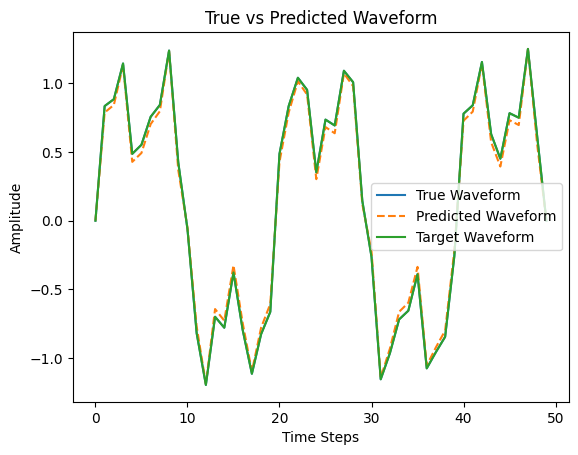

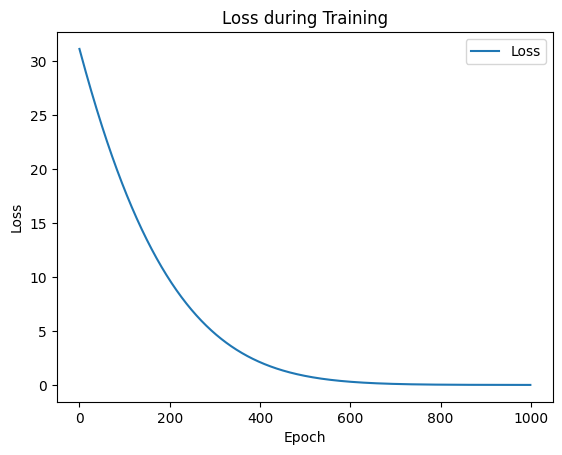

In [84]:
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torch.nn as nn

# 複雑な波形データを生成（複数のサイン波を合成）
def generate_complex_wave(seq_length=100, n_features=1, freqs=[0.1, 0.3, 0.5], amplitudes=[1, 0.5, 0.2]):
    t = np.linspace(0, seq_length * np.pi, seq_length)
    data = np.zeros_like(t)

    # 複数の周波数成分のサイン波を合成
    for f, a in zip(freqs, amplitudes):
        data += a * np.sin(t * f)

    return data.reshape(-1, 1)

# 訓練データの準備
seq_length = 50
n_features = 1  # 単一の特徴量（単一のチャネル）
freqs = [0.1, 0.3, 0.8]
amplitudes = [1, 0.5, 0.2]

train_data = torch.tensor(generate_complex_wave(500, n_features=1), dtype=torch.float32)
train_data = generate_complex_wave(seq_length=seq_length, n_features=n_features, freqs=freqs, amplitudes=amplitudes)
train_data = torch.tensor(train_data, dtype=torch.float32)

target_data = torch.tensor(generate_complex_wave(seq_length=seq_length, n_features=n_features, freqs=freqs, amplitudes=amplitudes), dtype=torch.float32)
target_data = torch.tensor(target_data, dtype=torch.float32)

# モデル初期化
N_u, N_y, N_x = 1, 1, 50
esn_model = ESN(N_u, N_y, N_x)

# 最適化設定
criterion = nn.MSELoss()
optimizer = optim.Adam(esn_model.parameters(), lr=1e-3)

# 訓練ループ
train_len = len(train_data)
loss_values = []  # lossの履歴を保存するリスト

for epoch in range(1000):  # エポック数を指定
    esn_model.reset_reservoir_state()  # リザバー状態をリセット
    optimizer.zero_grad()  # 勾配を初期化

    # モデルの順伝播
    predictions = esn_model(train_data)

    # ロス計算
    loss = criterion(predictions, target_data)

    # 誤差逆伝播
    loss.backward()  # retain_graph=Trueを外す
    optimizer.step()

    loss_values.append(loss.item())  # ロスの値を記録

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    # with torch.no_grad():
    #     esn_model.reset_reservoir_state()
    #     predicted_output = esn_model(target_data).detach().numpy()
    #     predicted_output = predicted_output.transpose(0,1)
    #     print(len(predicted_output))

# 訓練後のモデルで予測
esn_model.reset_reservoir_state()
predicted_output = esn_model(train_data).detach().numpy()
predicted_output = predicted_output.transpose(0,1)
print(len(predicted_output))

# 結果の描画
plt.plot(train_data.numpy(), label='True Waveform')
plt.plot(predicted_output, label='Predicted Waveform', linestyle='--')
plt.plot(target_data.numpy(), label='Target Waveform', linestyle='solid')
plt.legend()
plt.title('True vs Predicted Waveform')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.show()

# ロスの描画
plt.plot(loss_values, label='Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [100/1000], Loss: 0.0014513895148411393
Epoch [200/1000], Loss: 0.00038619808037765324
Epoch [300/1000], Loss: 0.0003834482340607792
Epoch [400/1000], Loss: 0.00038015563040971756
Epoch [500/1000], Loss: 0.00037635621265508235
Epoch [600/1000], Loss: 0.0003720844688359648
Epoch [700/1000], Loss: 0.00036736816400662065
Epoch [800/1000], Loss: 0.00036222863127477467
Epoch [900/1000], Loss: 0.00035668129567056894
Epoch [1000/1000], Loss: 0.00035074216430075467


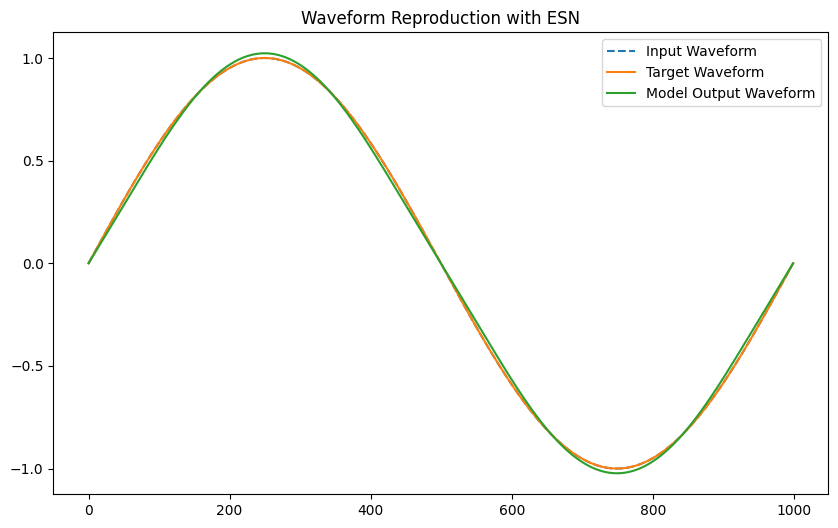

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 波形データの生成
def generate_waveform(timesteps, frequency=1.0, amplitude=1.0, phase=0.0):
    """
    シンプルな正弦波を生成する関数
    """
    t = torch.linspace(0, 2 * torch.pi, timesteps)
    return amplitude * torch.sin(frequency * t + phase)

# ESNモデルをテストする関数
def test_esn_waveform():
    # テスト用のパラメータ
    N_u = 1  # 入力次元 (波形は1次元)
    N_y = 1  # 出力次元 (波形は1次元)
    N_x = 50  # リザバーのニューロン数
    timesteps = 1000 # 時間ステップ数

    # モデルの初期化
    model = ESN(N_u, N_y, N_x)

    # 入力波形と目標波形の生成
    waveform_input = generate_waveform(timesteps).view(-1, 1)  # 入力波形
    target_output = waveform_input.clone()  # 目標は同じ波形

    # 損失関数とオプティマイザの設定
    criterion = nn.MSELoss()  # 平均二乗誤差
    optimizer = optim.Adam(model.Output.parameters(), lr=0.01)

    # 学習ループ
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()

        # モデルの出力計算
        outputs = []
        model.reset_reservoir_state()  # リザバーの状態をリセット
        for u in waveform_input:
            y = model(u)
            outputs.append(y)

        outputs = torch.stack(outputs).view(-1, 1)

        # 損失計算とバックプロパゲーション
        loss = criterion(outputs, target_output)
        loss.backward()
        optimizer.step()

        # 定期的に損失を表示
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

    # 結果のプロット
    with torch.no_grad():
        test_outputs = []
        model.reset_reservoir_state()
        for u in waveform_input:
            y = model(u)
            test_outputs.append(y)

        test_outputs = torch.stack(test_outputs).view(-1, 1)

    plt.figure(figsize=(10, 6))
    plt.plot(waveform_input.numpy(), label="Input Waveform", linestyle="--")
    plt.plot(target_output.numpy(), label="Target Waveform")
    plt.plot(test_outputs.numpy(), label="Model Output Waveform")
    plt.legend()
    plt.title("Waveform Reproduction with ESN")
    plt.show()

# テストの実行
test_esn_waveform()
